# Lab Four: Evaluation and Multi-Layer Perceptron

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Dataset Selection](#data)<br>
 2. [Preparation](#prep)<br>
  2.1 [Business Case](#business_case)<br>
  2.2 [Define Class Variables](#class_variables)<br>
  ...2.2.1 [Discharge Disposition IDs](#dis_disp)<br>
 3. [Evaluation](#eval)<br>
  3.1 [Metric](#metric)<br>
  3.2 [Test-Train Split](#split)<br>
 4. [Modeling](#modeling)<br>
  4.1 [Multi-Layer Perceptron](#mlp)<br>
  4.2 [Hyper Parameter](#hyper_parameters)<br>
  4.3 [Visualize Gradients](#visualize)<br>
 5. [Exceptional Work](#exceptional)<br>
  4.1 [Additional Analysis](#additional_analysis)<br>
  ...4.1.1 [Important Features](#important_features)<br>
  4.2 [Phi Functions](#phi_functions)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (put the html anchors above the titles for better scrolling)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

<a id="data"></a>
## Dataset Selection
Select a dataset identically to the way you selected for lab one or lab three (table data or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains __three or more classes__ to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

<a id="prep"></a>
## Preparation __(15 points total)__

<a id="business_case"></a>
### Business Case / Use Case

>__[5 points]__ _(mostly the same processes as from previous lab)_ Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?

For this project we will return to the [diabetes dataset](https://toolbox.google.com/datasetsearch/search?query=diabetes&docid=nNaPT3seeZMO6VmgAAAAAA%3D%3D) we used for Lab1. Briefly, this dataset contains information regarding diabetic patients who were admitted to the hospital.

This dataset contains labels that characterize whether the patient was readmitted to the hospital in less than 30 days, readmitted to the hospital after more than 30 days, or not readmitted at all. Predicting these labels will be our classification task. 

There are two potential sets of parties interested in these results. 

- First, emergency medical care centers. These care centers will likely be interested in the results because of the insight they may provide for the day to day operations of the centers. We may discover that certain types of patients are much more likely to be readmitted to an emergency medical care center. This information could be used by the care centers to provide extra attention to the most at-risk patients once identified. In this case, the model would likely be deployed so that the healthcare professionals can have feedback as soon as possible. Throughout this project, we will focus on this possibility so as not to split our time and energy.

- Second, special focus groups, such as the [American Diabetes Association](http://www.diabetes.org/). These organizations can use the insight gained from our studies to issue standards or suggestions. These standards or suggestions could then be implemented at individual care centers. Since the ADA is a large organization with a relative large sphere of influence, these suggestions could help ensure parity accross a variety of care centers. In this case, the model would mostly be used for offline analysis. For this project, we will not focus on this possibility.

For this lab we will focus on the first potential interested party.

<a id="class_variables"></a>
### Define Class Variables

> __[10 points]__ _(mostly the same processes as from lab one)_ Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. __Describe the final dataset that is used for classification__ (include a description of any newly formed variables you created).

This section is very similar to the previous labs, with the exception of the additonal analysis of the dishcarge disposition ids. Briefly, we dropped the instances where the patient was discharged because of death or the patient wene to hospice. We also slightly modified the one hot encoding.

In [1]:
# load the full dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.style.use('ggplot')
%matplotlib inline

full_df = pd.read_csv('data/diabetic_data.csv')

full_df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

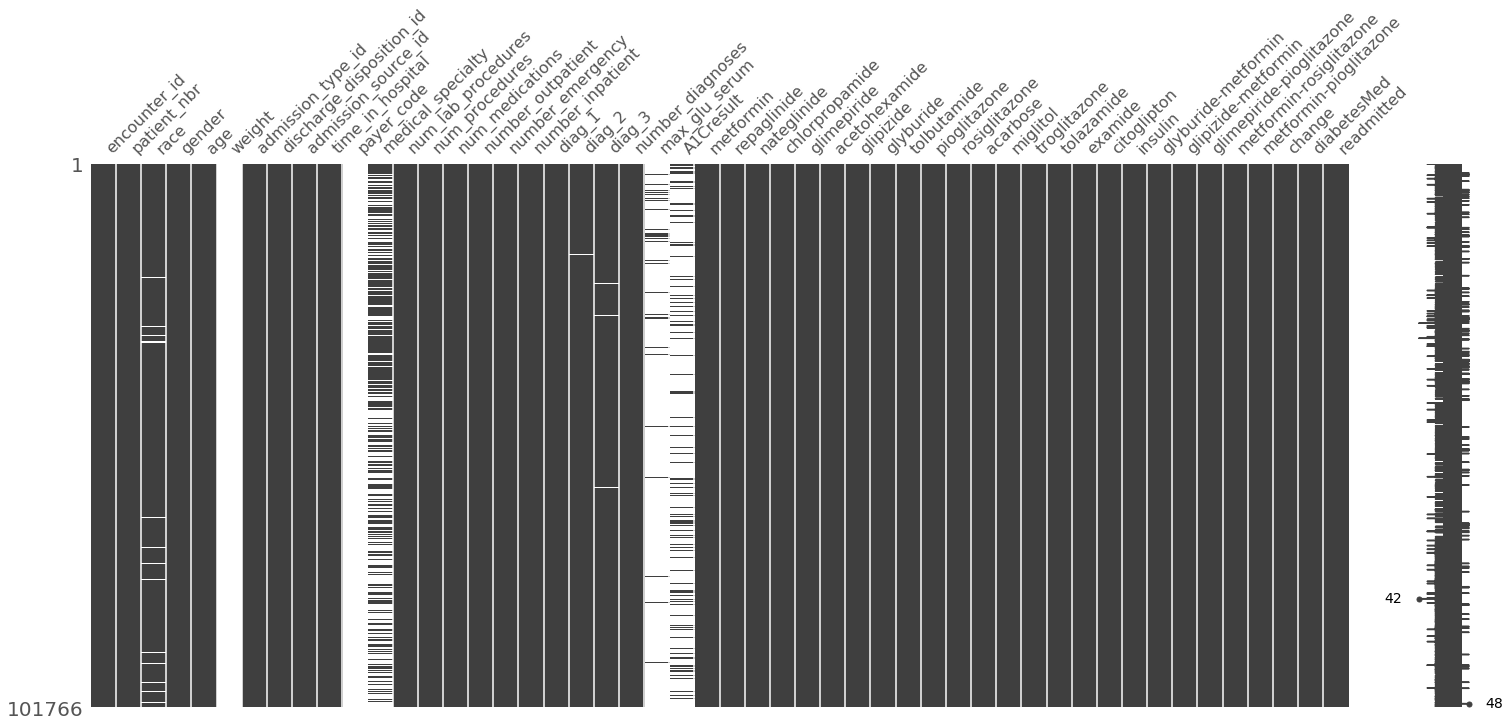

In [3]:
# now convert columns that should be numeric to numeric types,

import os
if os.getcwd().find('jamesthomas'):
    import sys
    sys.path.append('/users/jamesthomas/python_packages/')
    import missingno as mn
        
# first force the columns that should be numeric to numeric
numeric_cols = ['weight','payer_code']
full_df[numeric_cols]=full_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# now replace the '?' in the string data
full_df.replace({'?':None,'None':None}, inplace = True)
mn.matrix(full_df)

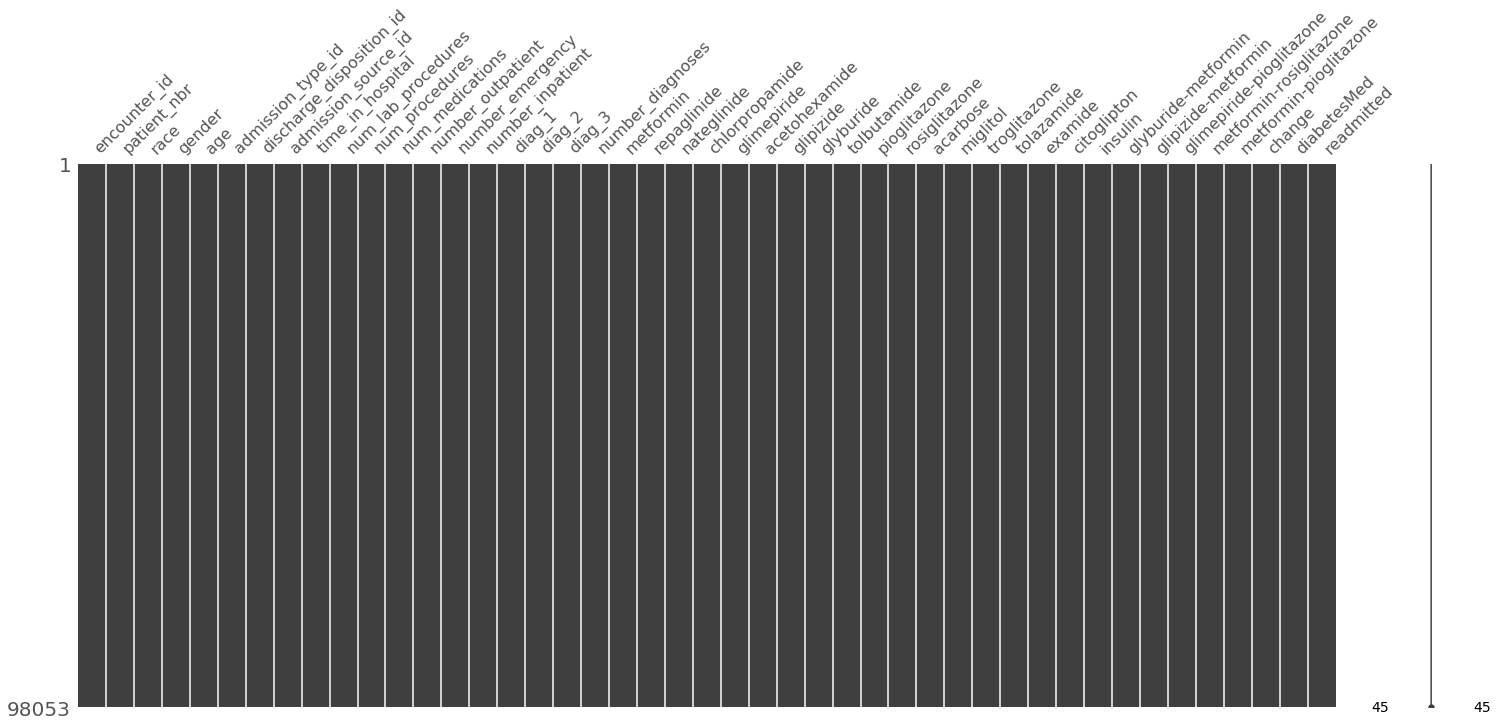

In [4]:
# then drop the columns missing too much data and then the rows with any missing data. 

cols = list(full_df)
datas = list(full_df.isnull().sum())
size = full_df.shape[0]
drop_cols = []
threshold = 0.08
for i in range(len(cols)):
    if datas[i]/size > threshold:
        drop_cols.append(cols[i])

full_df.drop(drop_cols, axis=1, inplace=True)
full_df.dropna(inplace=True)

mn.matrix(full_df)

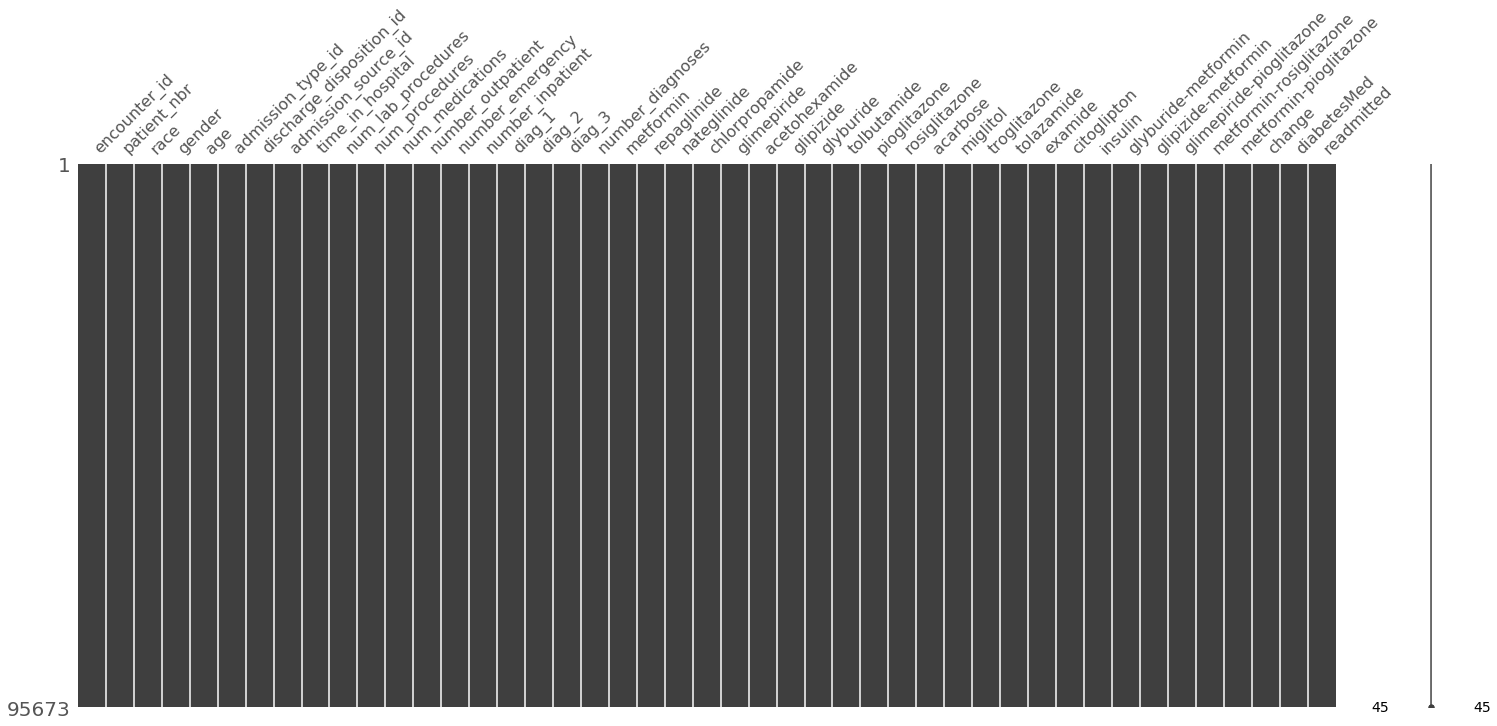

In [5]:
# now drop some rows based on discharge disposition
discharge_disp_ids = [11, 13, 14, 19, 20, 21]
full_df = full_df.loc[~full_df.discharge_disposition_id.isin(discharge_disp_ids)]
mn.matrix(full_df)

<a id='dis_disp'></a>
### Discharge Disposition ID

In addition to the previous data cleaning, we have dropped some of the discharge dispositions ids. The dropped ids are

- 11: Expired
- 13: Hospice / home
- 14: Hospice / medical facility
- 19: Expired at home. Medicaid only, hospice
- 20: Expired in a medical facility. Medicaid only, hospice
- 21: Expired, place unknown. Medicaid only, hospice

We dropped these ids because these patients can not be readmitted. Although there were only 3280 instances that we dropped (about 2.5% of the previous data), they could skew our results.

In [6]:
# some helper functions for data conversion
def one_hot_encode(df, column):
    '''If the column only contains a single value, there is no information so don't do anything,
    otherwise one hot encode the column
    '''
    col_names = []
    if len(df[col].unique()) != 1:
        # more than one value in category
        df[column] = pd.Categorical(df[column])
        dfDummies = pd.get_dummies(df[column], prefix = column+'_category', drop_first=True) # added drop_first
        col_names.append(list(dfDummies))
        df = pd.concat([df, dfDummies], axis=1)
    return df, col_names

def diag_categorize(val):
    '''More information about the categories can be found at http://www.icd9data.com/
    '''
    try:
        val = float(val)
        if val < 140:
            return('Infectious and Parasitic Disease')
        elif val < 240:
            return('Neoplasms')
        elif val < 280:
            return('Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders')
        elif val < 290:
            return('Diseases Of The Blood And Blood-Forming Organs')
        elif val < 320:
            return('Mental Disorders')
        elif val < 390:
            return('Diseases Of The Nervous System And Sense Organs')
        elif val < 460:
            return('Diseases Of The Circulatory System')
        elif val < 520:
            return('Diseases Of The Circulatory System')
        elif val < 580:
            return('Diseases Of The Digestive System')
        elif val < 630:
            return('Diseases Of The Genitourinary System')
        elif val < 680:
            return('Complications Of Pregnancy, Childbirth, And The Puerperium')
        elif val < 710:
            return('Diseases Of The Skin And Subcutaneous Tissue')
        elif val < 740:
            return('Diseases Of The Musculoskeletal System And Connective Tissue')
        elif val < 760:
            return('Congenital Anomalies')
        elif val < 780:
            return('Certain Conditions Originating In The Perinatal Period')
        elif val < 800:
            return('Symptoms, Signs, And Ill-Defined Conditions')
        else:
            return('Injury And Poisoning')
    except:
        if val[0]=='V':
            return('Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services')
        elif val[0]=='E':
            return('Supplementary Classification Of External Causes Of Injury And Poisoning')
        else:
            print(val)
            return(None)

In the `one_hot_encode function`, we added the `drop_first=True` parameter for this lab. This way we do not include columns that can be directly inferred from other columns. 

In [7]:
# these are the columns that use the ICD9 data

explain_list = ['diag_1', 'diag_2', 'diag_3']
for diag in explain_list:
    full_df[diag+'_explain'] = full_df[diag].apply(diag_categorize)

In [8]:
# these are the columns that need one hot encoded

one_hot_encode_list = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
                       'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
                       'tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin',
                       'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                       'diag_1_explain','diag_2_explain','diag_3_explain','race','admission_type_id',
                       'discharge_disposition_id','admission_source_id','insulin']

# the names are so we don't use standard scalar on one hot encoded columns
one_hot_encoded_names = []
for col in one_hot_encode_list:
    full_df, one_hot_names = one_hot_encode(full_df, col)
    one_hot_encoded_names.append(one_hot_names)

full_df.drop(one_hot_encode_list+explain_list, axis=1, inplace=True)

In [9]:
# Now we will convert the 'patient_nbr' column to a new column that shows counts how many times the patient visitied
# the hospital in the study

full_df['freq'] = full_df.groupby('patient_nbr')['patient_nbr'].transform('count')

In [10]:
# these are the columns that are no longer relevant, either because we transformed the data or it is just an id

drop_not_relevant = ['encounter_id', 'patient_nbr']
full_df.drop(drop_not_relevant, axis=1, inplace=True)

In [11]:
# now label encoding
full_df['age'] = full_df['age'].replace({'[0-10)':0,'[10-20)':1,'[20-30)':2,'[30-40)':3,'[40-50)':4,
                                         '[50-60)':5,'[60-70)':6,'[70-80)':7,'[80-90)':8,'[90-100)':9})
full_df['gender'] = full_df['gender'].replace({'Male':0,'Female':1,'Unknown/Invalid':None})
full_df['change'] = full_df['change'].replace({'Ch':0,'No':1})
full_df['diabetesMed'] = full_df['diabetesMed'].replace({'Yes':0,'No':1})

In [12]:
full_df.dropna(inplace=True) # to drop any None types that come up from the conversions

In [13]:
# normalize the columns so that the response is not dominated by a few columns with large values
       
standard_scalar_list = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                        'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'freq']

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
full_df[standard_scalar_list] = scalar.fit_transform(full_df[standard_scalar_list])

In [14]:
# not look at what we have left
full_df.describe()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_source_id_category_13,admission_source_id_category_14,admission_source_id_category_17,admission_source_id_category_20,admission_source_id_category_22,admission_source_id_category_25,insulin_category_No,insulin_category_Steady,insulin_category_Up,freq
count,95672.000000,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,9.567200e+04,...,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,95672.000000,9.567200e+04
mean,0.539301,-3.456516e-14,-3.376686e-14,-1.039478e-15,-1.666827e-14,9.805043e-15,-5.780101e-14,-4.913490e-14,1.428391e-14,-9.662723e-14,...,0.000010,0.000021,0.066822,0.001651,0.000125,0.000021,0.469897,0.298928,0.110544,2.971940e-14
std,0.498456,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,0.003233,0.004572,0.249715,0.040605,0.011199,0.004572,0.499096,0.457790,0.313569,1.000005e+00
min,0.000000,-3.914992e+00,-1.144178e+00,-2.135590e+00,-7.888830e-01,-1.867351e+00,-2.937251e-01,-2.137232e-01,-5.062920e-01,-2.442879e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.212538e-01
25%,0.000000,-7.080583e-01,-8.081643e-01,-6.085779e-01,-7.888830e-01,-6.289132e-01,-2.937251e-01,-2.137232e-01,-5.062920e-01,-8.117243e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.212538e-01
50%,1.000000,-6.667146e-02,-1.361375e-01,5.312749e-02,-2.026042e-01,-1.335380e-01,-2.937251e-01,-2.137232e-01,-5.062920e-01,2.757123e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.212538e-01
75%,1.000000,5.747154e-01,5.358892e-01,7.148329e-01,3.836746e-01,4.856809e-01,-2.937251e-01,-2.137232e-01,2.819837e-01,8.194306e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.059872e-01
max,1.000000,1.857489e+00,3.223996e+00,4.532364e+00,2.728790e+00,8.040152e+00,3.248380e+01,7.974907e+01,1.604750e+01,4.625459e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.519632e+01


In [16]:
# now save the csv and pickle so we don't have to rerun these cells each time
# on a side note, is there a better format, maybe automatically zip, or HDF (for numeric data)?
full_df.to_csv('data/processed_data.csv',index=False)
full_df.to_pickle('data/processed_data.pickle')

<a id="eval"></a>
## Evaluation (30 points total)


<a id="metric"></a>
### Metric

>__[15 points]__ Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a __detailed argument for why this (these) metric(s) are appropriate__ on your data. That is, why does the metric evaluate performance in terms of the business case you argued for. Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

In an ideal world, we would want to use a metric that is widely used in the medical analysis field so that we could directly compare our model with others. However, we have not been able to find many publications about this. We did find one [paper](https://www.hindawi.com/journals/bmri/2014/781670/), but it appears to be using the dataset to answer a different question than we are. The authors are analyzing the impact of the hemoglobin a1c result and we dropped that featrue because it was missing too much data. The paper also makes extensive use of the [P-value](https://www.dummies.com/education/math/statistics/what-a-p-value-tells-you-about-statistical-data/) which is an acceptable method for hypothesis testing, but it does not apply a quantitative value that describes the "goodness" of our model. There are also [references](https://www.ischool.berkeley.edu/projects/2017/what-are-predictors-medication-change-and-hospital-readmission-diabetic-patients) using, precision, recall, area under the ROC curve, and accuracy. 

Since there does not appear to be a single, widely used, metric used. We will define our own. To do this we will define a cost matrix which reflects the relative cost of false positives, false netatives, and correct predictions by our model. This cost matix will then be multiplied by the confusion matrix predicted by our model and the resulting elements will be summed to create the aggregate cost. Now we just have to define the relative cost of each mistake. A sample cost matrix could be:

<table>
<tr>
    <td colspan="2"></td>
    <td colspan="3">Actual Class</td>
</tr>
<tr>
    <td colspan="2"></td>
    <td>NO</td>
    <td>&gt;30</td>
    <td>&lt;30</td>
</tr>
<tr>
    <td rowspan="3">Predicted Class</td>
    <td>NO</td>
    <td>neither good nor bad</td>
    <td>really bad</td>
    <td>really bad</td>
</tr>
<tr>
    <td>&gt;30</td>
    <td>bad</td>
    <td>good</td>
    <td>not so bad</td>
</tr>
<tr>
    <td>&lt;30</td>
    <td>bad</td>
    <td>not so bad</td>
    <td>good</td>
</tr>
</table>

- If the predicted class and actual class are both NO there is no cost or benefit, this value is neutral overall.

- If the predicted class matches the actual class for either of the readmitted labels, a small benefit (negative cost) is included. For these patients the model predicted correctly, but the real-world cost of false postives and false negatives are significantly higher than the benefits of predicting correctly.

- If the predicted class is >30 or <30 but the actual class is no, there is a relatively small cost incurred. These patients would likely undergo additional testing at the hospital or stay in the hospital for an additional day, but the cost of these additional test or time in the hospital is significantly less than what an additional hospital visit would be.

- The highest cost comes when the predicted class is NO, but the actual class is >30 or <30. The cost of these elements will have to reflect the real world cost of a return hospital visit.

- Finally, the difference between >30 and <30 will be relatively small compared to the difference between NO and either of the readmitted labels.

An example of the cost matrix with numeric values attached to each category is seen below. To improve on this cost matrix, we would likely have to speak to medical professionals. These professionals likely know the average cost af a day in a hospital and the average cost of a hospital visit to scale the cost of the "bad" and "really bad" elements in the cost matrix. Since the average cost of a hospital stay varies significanly based on the reason the patient is visiting the hospital, we could do better by using the average cost of a hospital stay for a diabetic. However, hospitals generally don't release this information publically. There is also a large difference in the prices depending on whether or not a patient has insurance or not. 

As one final note, we chose to make the minimum cost in the cost matrix 0 instead of a negative number. This will not affect our results because we are using the same matrix throughout the project and are simply searching for the minimum cost. This will shift what the minimum cost is, but will not shift where it occurs.

In [3]:
# the cost matrix
import numpy as np
import pandas as pd

sample_cost_matrix = np.array([[1,  9, 10],
                               [4,  0,  2],
                               [5,  2,  0]])

cost_frame = pd.DataFrame(sample_cost_matrix)
cost_frame.columns = ["No", ">30", "<30"]
cost_frame.index = ["No", ">30", "<30"]
print('the cost frame')
cost_frame

the cost frame


,No,>30,<30
No,1,9,10
>30,4,0,2
<30,5,2,0


A sample implementation of the cost metric using the cost matrix is seen below.

In [21]:
def cost_metric_func(conf_matrix, cost_matrix):
    if cost_matrix.shape != conf_matrix.shape:
        print('The dimensions of the cost matrix do not match the dimensions of the confusion matrix. {} != {}'.format(confusion_matrix.shape, cost_matrix.shape))
        return None
    else:
        return(np.sum(conf_matrix * cost_matrix))

sample_confusion_matrix = np.ones(sample_cost_matrix.shape)
sample_cost = cost_metric_func(sample_confusion_matrix, sample_cost_matrix)
print('for a sample:')
print('cost matrix \n{}'.format(sample_cost_matrix))
print('confusion matrix \n{}'.format(sample_confusion_matrix))
print('the cost is {}'.format(sample_cost))

for a sample:
cost matrix 
[[ 0  9 10]
 [ 4 -1  2]
 [ 5  2 -1]]
confusion matrix 
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
the cost is 30.0


<a id="split"></a>
### Test-Train Split

>__[15 points]__ Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). __Explain why your chosen method is appropriate or use more than one method as appropriate__. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince the reader that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 
- __Important__: You should use your chosen evaluation criteria and chosen method for dividing train/test data throughout the report. For example, arguing that f-score is the best evaluation method, but then using accuracy in a grid search will be __regarded as a conceptual error__ and graded accordingly. 

In [22]:
# first, read in the previous processed data
import pickle

processed_df = pd.read_pickle('data/processed_data.pickle')
processed_df.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_source_id_category_13,admission_source_id_category_14,admission_source_id_category_17,admission_source_id_category_20,admission_source_id_category_22,admission_source_id_category_25,insulin_category_No,insulin_category_Steady,insulin_category_Up,freq
1,1.0,-3.273606,-0.472151,0.816634,-0.788883,0.237993,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,0,1,-0.521254
2,1.0,-2.632219,-0.808164,-1.626586,2.142511,-0.381226,1.267109,-0.213723,0.281984,-0.811724,...,0,0,0,0,0,0,1,0,0,-0.521254
3,0.0,-1.990832,-0.808164,0.053127,-0.202604,-0.009694,-0.293725,-0.213723,-0.506292,-0.268006,...,0,0,0,0,0,0,0,0,1,-0.521254
4,0.0,-1.349445,-1.144178,0.409430,-0.788883,-1.000445,-0.293725,-0.213723,-0.506292,-1.355443,...,0,0,0,0,0,0,0,1,0,-0.521254
5,0.0,-0.708058,-0.472151,-0.608578,2.728790,-0.009694,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,1,0,-0.521254


In [23]:
# show class imbalance

full_len = processed_df.shape[0]
for val in processed_df.readmitted.unique():
    count = sum(processed_df.readmitted == val)
    print('for {} a total of {} occurances for {:.3f}%'.format(val, count, count/full_len*100))

for >30 a total of 34606 occurances for 36.172%
for NO a total of 50043 occurances for 52.307%
for <30 a total of 11023 occurances for 11.522%


As a general rule of thumb, an 80/20 split for the training and testing data is a good starting point. The key point is to make sure that the full model space is covered by the training and testing data. In our case we have plenty of data, so we may be able to use slightly less than 20% if we needed to speed up the training. However, the training time is reasonable for now so we stuck with an 80/20 split.

The biggest potential problem we have with our dataset is the class imbalance. Approximately 52% of the remaining data is "NO", 36% is ">30" and the remaining 12% is "<30". To account for this imbalance we have a few options.  We could also sub-sample the dominating class (NO, then >30). In doing this we will be throwing away possible information that is contained in the dropped rows. This is not ideal, especially for small data sets. Another possibility is to repeatedly include instances from the less represented labels until all of the labels are roughly equally represented, or over-sample. This is preferred over sub-sampling the dominating class because it is not throwing away any potential data. It does generate a larget dataset to work with so practical limitations may have to be considered for really large datasets (like those that don't fit into RAM). 

Another option is to use a stratified method for splitting the data. This will ensure that all of the readmitted labels are represented in each of the subsets of data. Since we are splitting the data into testing and training (not yet cross validation) we can simply add the `stratify` parameter to the `test_train_split` call. 

In [24]:
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit

# split the data and the target
data_cols = list(processed_df)
data_cols.remove('readmitted')
data = processed_df[data_cols]
target = processed_df['readmitted']

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0, stratify=target)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(76537, 155) (76537,)
(19135, 155) (19135,)


<a id="modeling"></a>
## Modeling (45 points total)

> All modeling code must be written using only the instructor's template code. Do NOT copy this implementation form anywhere online. Not fully implementing the back propagation algorithm will result in a zero for the entire assignment.

We can write the cost function in the following fashion:

\begin{equation*}
{\rm{cost}\_ \rm{function}} = f_i \bigg( \phi_{i} \left( M_i \phi_{i-1}(M_{i-1} N_{i-2}+b_{i-1}) + b_i \right) \bigg)
\end{equation*}

in which, $f_i$ represents all the afterward layers and the cost function definition, $b_i$ is the bias term for the $i$-th layer, and $N_i$ is the neuron value of the $i$-th layer, $V_i$ is the value before we apply the activation function($V_i = M_{i} N_{i-1}+b_{i}$). 

We find that:

\begin{align*}
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial M_i} &= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i) \times N_{i-1} \\
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial b_i} &= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i) \\
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial M_{i-1}} &= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i)* M_{i} \times \phi_{i-1}^{'}(V_{i-1}) \times N_{i-2}\\
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial b_{i-1}} &= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i) \times M_{i} \times \phi_{i-1}^{'}(V_{i-1})
\end{align*}

In principle we can also write the third equation as,

\begin{equation*}
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial M_{i-1}} = f_{i-1} ^{'}(N_{i-1}) \times \phi_{i-1}^{'}(V_{i-1}) \times N_{i-2}
\end{equation*}

which gives us that

\begin{equation*}
 f_{i-1} ^{'}(N_{i-1})= f_i ^{'}(N_{i}) \times \phi_{i}^{'}(V_i) \times M_{i}
\end{equation*}

We can refer to $f_i ^{'}(N_{i})$ as the derivative_prefix, and as long as we can keep track of the derivative_prefix in different layers, we can calculate the partial derivative of each layer efficiently.

Note that, in the formulas above, we only show the ingredients of every equation for the purpose of simplicity, in the actual formula, we need to move the matrix around and use different multiplications carefully.

The actual iterations are as follow:

\begin{align*} 
 f_{i-1} ^{'}(N_{i-1}) &=  M_{i}^T@f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i) \\
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial M_i} &= f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i)@ N_{i-1}^T \\
\frac{\partial (\rm{cost}\_ \rm{function})}{\partial b_i} &= f_i ^{'}(N_{i}) * \phi_{i}^{'}(V_i) @ I
\end{align*}

In the last formula, $I$ is a matrix with value 1, $@$ represents matrix multiply,  and $*$ reperesents elementwise multiplication.


We start with the last layer, and the initial derivative_prefix is the derivative of the cost_fuction (either mean square error or cross entropy).

In [8]:
'''
definition of customized cost function, similar to above with a few more checks in place
'''
def find_cost_metric(y_true, y_pred, cost_matrix):
    conf_matrix = confusion_matrix(y_true, y_pred)
    if cost_matrix is None:
        # check if the user passed a cost matrix
        print('No cost matrix passed, using ones')
        cost_matrix = np.ones(conf_matrix.shape)
    if (cost_matrix < 0).all():
        # make sure they are all positive
        cost_matrix = cost_matrix - np.min(cost_matrix)
    cost_matrix = cost_matrix/len(y_true) # normalize for bounds       
    return(np.sum(conf_matrix * cost_matrix))

my_cost_matrix = np.array([[1,  9, 10],
                           [4,  0,  2],
                           [5,  2,  0]])

In [13]:
# the object we will be using with the various pieces implemented
class Sequential(object):
    def __init__(self, C=0.0, epochs=500, eta=0.001, random_state=None, 
                 cost_function='quadratic', 
                 metric='accuracy',
                 verbose=1,
                 regular='None',
                 learning_rate = no_decay,
                 early_stopping=False):
        np.random.seed(random_state)
        self.C = C
        self.epochs = epochs
        self.eta = eta
        self.cost_function = cost_function
        self.metric = metric
        self.verbose = verbose
        self.regular = regular
        self.early_stopping = early_stopping
        self.learning_rate = learning_rate
        
        self.dims = []
        self.acts = []
        
        self.matrice = []
        self.bias = []
        self.vects = [] #before the activation function
        self.neurons = [] #after the activation function
        self.dropout = [] #to be implemented later
        self.Y = []
        
        self.loss = []
        self.grad_norm = []
        
    def add(self,arg,argv):
        '''
        add('Dense',12)
        add('Dense',15)
        add('Activation',Sigmoid)
        add('Activation',Relu)
        add('Dropout',0.5)
        '''
        if arg == 'Dense':
            if len(self.dropout) < len(self.dims):
                self.dropout.append(0)
            if len(self.dims) == 0:
                self.dims.append([0,argv])
            else:
                self.dims.append([self.dims[-1][-1],argv])
                
            self.grad_norm.append([]) #keep track of the grad_norm
        if arg == 'Activation':
            self.acts.append(argv)
        if arg == 'Dropout':
            self.dropout.append(argv)
        return
    
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot

    def _initialize_params(self,X,Y):
        for row,col in self.dims:
            W_num_elems = row*col
            W = np.random.uniform(-1.0, 1.0, size=W_num_elems)
            W = W.reshape(col, row) # reshape to be W
            self.matrice.append(W)
            
            b = np.random.uniform(-1.0, 1.0, size=col)
            b = b.reshape(col, 1)
            self.bias.append(b) #adding bias vector
        
        self.neurons.append(X.T)
        self.Y = self._encode_labels(Y)
        return
    
    def activate(self,vec,act):
        return act.val(vec)
    
    def activate_dev(self,vec,act):
        return act.dev(vec)
    
    def _feedforward(self):
        '''
        clear the previous feedforward result
        '''
        self.neurons = self.neurons[:1]
        self.vects = []
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            self.vects.append(W @ self.neurons[-1] + b)
            self.neurons.append(self.activate(self.vects[-1],act))
        m = self.Y.shape[1]
        if self.cost_function == 'quadratic':
            self.loss.append(((self.neurons[-1]-self.Y)*(self.neurons[-1]-self.Y)).sum()/m)
        elif self.cost_function == 'cross_entropy':
            cost = -(1.0/m) * np.sum(self.Y*np.log(self.neurons[-1]) + (1-self.Y)*np.log(1-self.neurons[-1]))
            self.loss.append(cost)
        return

    def predict(self,X_test):
        neuron = X_test.T
        for W,b,act in zip(self.matrice,self.bias,self.acts):
            vec = W @ neuron + b
            neuron = self.activate(vec,act)
        y_pred = np.argmax(neuron, axis=0)
        return y_pred

    def set_init_dev_prefix(self):
        if self.cost_function == 'quadratic':
            return -2 * (self.Y - self.neurons[-1])
        if self.cost_function == 'cross_entropy':
            return -(self.Y-self.neurons[-1])

    def _update_params(self):
        cur_dev_prefix = self.set_init_dev_prefix()
        grads = []
        bias_grads = []
        for N,N1,V,act,W in zip(self.neurons[1:][::-1],self.neurons[:-1][::-1],self.vects[::-1],self.acts[::-1],self.matrice[::-1]):
            cur_dev_prefix *= self.activate_dev(V,act)
            grads.append(cur_dev_prefix @ N1.T)
            bias_grads.append(cur_dev_prefix @ np.full((cur_dev_prefix.shape[1], 1), 1))
            cur_dev_prefix = W.T @ cur_dev_prefix
        grads.reverse()
        bias_grads.reverse()
        
        if self.regular != 'None':
            for W,b,grad,bias_grad in zip(self.matrice,self.bias,grads,bias_grads):
                if 'L2' in self.regular:
                    grad += 2*self.C * W
                    bias_grad += 2*self.C * b
                if 'L1' in self.regular:
                    grad += ((W>0).astype(int)-0.5)*(2*self.C)
                    bias_grad += self.C *((b>0).astype(int)-0.5)*(2*self.C)
                    
        for W,grad,b,bias_grad,grad_n in zip(self.matrice,grads,self.bias,bias_grads,self.grad_norm):
            W -= self.eta * grad
            b -= self.eta * bias_grad
            
            grad_n.append(max(grad.max(),b.max()))#keep track of the grad norm
        return
    
    def fit(self,X,Y):
        self.dims[0][0] = X.shape[1]
        if len(np.unique(Y)) != self.dims[-1][-1]:
            print('Error: output dimension is wrong!')
            return False
        self._initialize_params(X,Y)
        eta_0 = self.eta

        for i in range(self.epochs):
            self.eta = self.learning_rate(eta_0,i,self.epochs)
            self._feedforward()
            self._update_params()

            if self.verbose and not i % max(1,int(self.epochs/10)):
                if self.metric == 'accuracy':
                    accu = accuracy_score(np.argmax(self.neurons[-1], axis=0),Y)
                    meas = 'accuracy'
                if self.metric == 'customized':
                    accu = find_cost_metric(Y,np.argmax(self.neurons[-1], axis=0),my_cost_matrix)
                    meas = 'customized cost'
                print('{} percent finished, current {} is {:.3f}.'.format(100*i//self.epochs,meas,accu))
        if self.verbose:
            print('Training is done!')
        return
    
    def plot(self):
        plt.figure()
        plt.plot([i for i in range(self.epochs-100)],self.loss[100:])
        plt.xlabel('Epoch number')
        plt.ylabel('Loss')
        plt.show()
        return
    def grad_plot(self):
        self.grad_norm = [np.array(arr)/self.Y.shape[1] for arr in self.grad_norm]
        ax = plt.subplot(1,1,1)
        for idx,arr in enumerate(self.grad_norm):
            plt.plot(abs(arr[100:]), label='w'+str(idx))
        plt.legend()
        plt.ylabel('Average gradient magnitude')
        plt.xlabel('Iteration')
        plt.show()
        return

<a id="mlp"></a>
### Multi-Layer Perceptron

>__[20 points]__ Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
- When instantiated, use a selectable phi function for the initial layer: either sigmoid or linear
- Use a selectable cost function when instantiated: either quadratic or cross entropy
- Add support for any number of hidden layers (user customizable).

For this we will use the `Sequential` object defined above in a sample demonstration of its usage.

In [6]:
full_df = pd.read_csv('data/processed_data.csv')

Y = full_df['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values
data_cols = list(full_df)
data_cols.remove('readmitted')
X = full_df[data_cols].values

In [19]:
'''
sample for demostrating how to use the Sequential model
'''
if True:
    model = Sequential(C=0.001, epochs=500, eta=0.00001, random_state=42, 
                     cost_function='cross_entropy', 
                     metric='customized',
                     verbose=1,
                     regular='L1',
                     learning_rate=no_decay)
    
    #no need for specifying the dimension of the input data, the model with configurate it when calls fit function
    model.add('Dense',20)
    model.add('Activation',Relu)# adding a dense layer with 20 neurons, and the activation function is Relu
    #model.add('Dropout',0.9) #defining the dropout, not implemented yet
    
    model.add('Dense',3)
    model.add('Activation',Sigmoid) # adding a dense layer with 3 neurons, and the activation function is Sigmoid



    model.fit(X,Y)

0 percent finished, current customized cost is 5.387.
10 percent finished, current customized cost is 2.718.
20 percent finished, current customized cost is 2.572.
30 percent finished, current customized cost is 2.495.
40 percent finished, current customized cost is 2.586.
50 percent finished, current customized cost is 2.427.
60 percent finished, current customized cost is 2.408.
70 percent finished, current customized cost is 2.367.
80 percent finished, current customized cost is 2.332.
90 percent finished, current customized cost is 2.301.
Training is done!


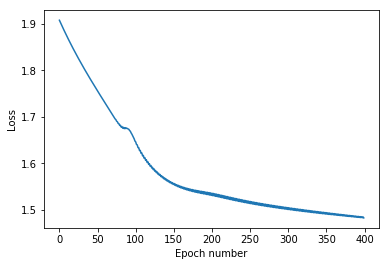

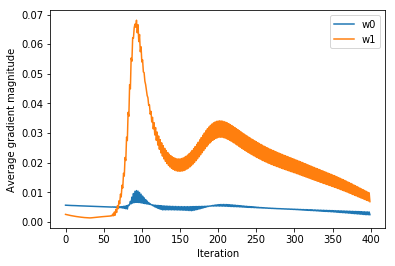

In [18]:
y_pred = model.predict(X) #for predicting
cost = find_cost_metric(Y,y_pred,my_cost_matrix) #for customized cost function
model.plot() #for plotting the loss function during training
model.grad_plot() #for plotting the grad of each layer during training

In the above sample code, the gradient is fluctuiting because we used an eta value that was too large.

<a id="hyper_parameters"></a>
### Hyper Parameters

>__[15 points]__ Tune the hyper-parameters of your MLP model (phi function, objective function, and number of layers). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. __Visualize the evaluation metric(s) versus the hyper-parameters__. Conclude what combination of parameters are best.

For this we implemented a custom grid search using multiprocessing. Depending on the number of points checked in parameter space this could take a while to run.

In [101]:
'''
modify the model to apply the grid search
'''

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

def estimator(param):
    model = Sequential(C=0, epochs=1000, eta=0.00001, random_state=42, 
                 cost_function=param['cost_function'], 
                 metric='accuracy',
                 verbose=0,
                 regular='None',
                 learning_rate=no_decay)
    for neu_nbr, act in zip(param['Layers'],param['Activations']):
        model.add('Dense',neu_nbr)
        model.add('Activation',act)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    acc = find_cost_metric(y_test,y_pred,my_cost_matrix)
    return acc

In [35]:
'''
create grid search parameters, in total testing 72 sets of parameters 
'''

import random
param_test = []
activation_list = [Linear,TANH,Sigmoid,Relu,ArcTan,SiLU]*5
for cost_function in ['cross_entropy','quadratic']:
    for layer_nbr in range(2,8,1):
        for k in range(6):
            #for same objective function and nbr of layers, create 6 sets of parameters
            neuron_list = [20 for i in range(layer_nbr-1)] + [3]
            #neuron number of hidden layers vary from 5 to 40
            random.shuffle(activation_list)
            act_list = activation_list[:layer_nbr-1] + [Sigmoid]
            #activation function of hidden layers are randomly selected
            tmp_param = {'cost_function':cost_function,'Layers':neuron_list,'Activations':act_list}
            param_test.append(tmp_param)

In [36]:
import multiprocessing as mp
n_core = mp.cpu_count()
print(n_core)

36


In [37]:
'''
use multi-processing for the grid search
'''
pool = mp.Pool(processes=n_core)
cost_list = pool.map(estimator,param_test)
print(cost_list)

[2.31079174287954, 2.3188920825712045, 2.270760386725895, 2.3188920825712045, 2.3188920825712045, 2.270760386725895, 2.36101384896786, 2.3458061144499607, 2.354533577214528, 2.3457538541938856, 2.384217402665273, 2.336033446563888, 2.34460412856023, 2.3902795923700024, 2.3147635223412593, 2.309171674941207, 2.3710478181343086, 2.315913247974915, 2.2532532009406845, 2.0879540109746535, 2.246041285602299, 2.2015678076822573, 2.2764044943820223, 2.3920564410765612, 2.317010713352495, 2.3046772929187354, 2.212385680689835, 2.342879540109746, 2.4115495165926313, 2.1855239090671543, 2.350405016984583, 2.1525476874836684, 2.367964463025869, 2.2421217663966555, 2.373556310425921, 2.2426966292134827, 2.260360595766919, 2.340318787562059, 2.343349882414423, 2.144865429840606, 2.260360595766919, 2.282257643062451, 2.1490462503266263, 2.100600992944865, 2.1490462503266263, 2.0597857329500915, 2.1451267311209823, 2.260099294486543, 2.0218447870394565, 2.1207734517899137, 2.101959759602822, 2.075516

Now we can start visualizing the costs found above.

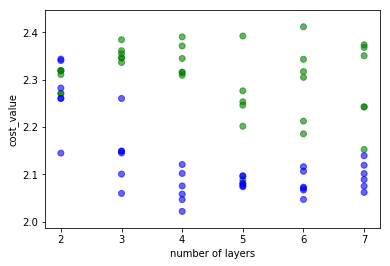

In [38]:
x_axis = [len(param_set['Layers']) for param_set in param_test]
y_axis = cost_list
c = ['blue' if param_set['cost_function']=='quadratic' else 'green' for param_set in param_test]
plt.scatter(x_axis, y_axis, alpha=0.6,c=c)
plt.xlabel('number of layers')
plt.ylabel('cost_value')
plt.show()

From the above graph(green: cross entropy, blue: quadratic), we notice two things:

1. Since the cost_value defined is roughly negatively propotional to the accuracy, it shows that the mean square error is much better than the cross entropy as the objective function overall.

2. As we increase the number of layers, the accuracy first increases, then starts decreasing, and reaches maximum when there are 4 layers. We did another gird search where the number of neorons in each layer is a random number between 5 to 40, it also shows that when the number of layers is 4 gives the best accuracy.

Note that, in the search above we didnt exploit all possible combinations of activiation functions, we will run another analysis below. But lets check what is the best set of parameters we found so far.

Also, we ran this grid search multiple times, and the best set of parameters always has Linear as the activation function in the first layer.

In [39]:
best_param_idx = sorted(list(enumerate(cost_list)),key=lambda l:l[1])[0][0]
best_param = param_test[best_param_idx]
best_param

{'cost_function': 'quadratic',
 'Layers': [20, 20, 20, 3],
 'Activations': [__main__.Linear,
  __main__.Relu,
  __main__.Linear,
  __main__.Sigmoid]}

Since Relu and SiLU are similar, and TANH, Sigmoid, ArcTan, and Linear are similar (in a sense that the derivative is a even function which is non-zero when x < 0), we will just replace the activation function of the second layer and third layer, and leave the rest untouched.

In [19]:
param_test_1 = []
for act1 in [Relu,SiLU]:
    for act2 in [TANH,Sigmoid,ArcTan,Linear]:
        neuron_list = [20 for i in range(3)] + [3]
        act_list = [Linear,act1,act2,Sigmoid]
        tmp_param = {'cost_function':'quadratic','Layers':neuron_list,'Activations':act_list}
        param_test_1.append(tmp_param)

In [20]:
pool = mp.Pool(processes=8)
cost_list_1 = pool.map(estimator,param_test_1)
print(cost_list_1)

[2.0616671021688004, 2.0475568330284815, 2.026286908805853, 2.0218447870394565, 2.0519989547948785, 2.0445779984321923, 2.029161222889992, 2.042174026652731]


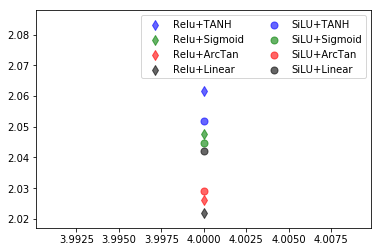

In [91]:
x_axis = [len(param_set['Layers']) for param_set in param_test_1]
y_axis = cost_list_1
marker = ['d' if param_set['Activations'][1]==Relu else 'o' for param_set in param_test_1]
def color(act):
    if act == TANH:
        return 'blue'
    if act == Sigmoid:
        return 'green'
    if act == Linear:
        return 'black'
    return 'red'
c = [color(param_set['Activations'][2]) for param_set in param_test_1]

for i in range(len(marker)):
    plt.scatter(x_axis[i],y_axis[i], marker=marker[i], color=c[i],alpha=0.6,s=50)

plt.legend(['Relu+TANH', 'Relu+Sigmoid', 'Relu+ArcTan', 'Relu+Linear', 'SiLU+TANH', 'SiLU+Sigmoid', 'SiLU+ArcTan', 'SiLU+Linear'],
          loc='upper right',
           ncol=2,
           fontsize=10)
plt.show()

From the diagram above, we find that Relu and SiLU tend to have similar behavior with Relu having a larger variance. This is because the derivative for Relu disappears when $x<0$, thus, if the epoch number is not large enough (heavily depends on the number of epochs), the result is not that good. However Relu can be more accurate than SiLU when the train __what__ is long enough.

Iit's clear from the second graph, ArcTan and Linear gives a better result than Sigmoid or TANH under the same setting.

So the best set of parameters stays unchanged.

<a id="visualize"></a>
### Visualize Gradients

>__[10 points]__ Visualize the magnitude of the gradients in each layer of the neural network versus the training iteration. Do the gradients stay consistent in each layer?

In [93]:
best_param_idx = sorted(list(enumerate(cost_list_1)),key=lambda l:l[1])[0][0]
best_param = param_test_1[best_param_idx]
best_param

{'cost_function': 'quadratic',
 'Layers': [20, 20, 20, 3],
 'Activations': [__main__.Linear,
  __main__.Relu,
  __main__.Linear,
  __main__.Sigmoid]}

In [ ]:
'''
best set of parameters, use such parameters to train for more epochs
'''
model = Sequential(C=0, epochs=1000, eta=0.000001, random_state=42, 
             cost_function=best_param['cost_function'], 
             metric='accuracy',
             verbose=1,
             regular='None',
             learning_rate=inverse_decay)
for neu_nbr, act in zip(best_param['Layers'],best_param['Activations']):
    model.add('Dense',neu_nbr)
    model.add('Activation',act)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
final_cost = find_cost_metric(y_test,y_pred,my_cost_matrix)
#print(final_cost)

0 percent finished, current accuracy is 0.509.


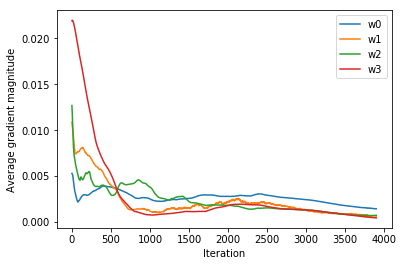

In [46]:
model.grad_plot()

From the figure shown above, we can see that at the begining, the gradient appears to be quite different in the different layers. After about 500 iterations the gradients are of the same scale. This is beacuse only the last layer's activation function is sigmoid. The other layers use linear or Relu. Since we are plotting the $L_\infty$ norm, they should be of the same scale.

<a id="exceptional"></a>
## Exceptional Work

<a id="additional_analysis"></a>
### Additional Analysis

> You have free reign to provide additional analyses.


<a id="important_features"></a>
#### Important Features

Along with the machine learning, it is often beneficial to try and find what features in the full dataset are most likely to contribute to the patient returning to the hospital. This may be useful to convey information to people who may not have a background in math, _e.g._ explaining what a principal component is to someone who hasn't had any math since high school. One way to provide this information is to use PCA to find the principal components, then apply the inverse of the PCA transform to an identity matrix. The first step will allow us to see what principal components contribute to the total variance the most. Applying the inverse transform to the identity matrix will then allow us to see how much each of the original features contributed to the principal components. Along the way we can also make some visualizations because staring at tables of weights is a quick way to put people to sleep.

In [25]:
# first, read in the previous processed data
import pickle

imp_df = pd.read_pickle('data/processed_data.pickle')
imp_df.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_source_id_category_13,admission_source_id_category_14,admission_source_id_category_17,admission_source_id_category_20,admission_source_id_category_22,admission_source_id_category_25,insulin_category_No,insulin_category_Steady,insulin_category_Up,freq
1,1.0,-3.273606,-0.472151,0.816634,-0.788883,0.237993,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,0,1,-0.521254
2,1.0,-2.632219,-0.808164,-1.626586,2.142511,-0.381226,1.267109,-0.213723,0.281984,-0.811724,...,0,0,0,0,0,0,1,0,0,-0.521254
3,0.0,-1.990832,-0.808164,0.053127,-0.202604,-0.009694,-0.293725,-0.213723,-0.506292,-0.268006,...,0,0,0,0,0,0,0,0,1,-0.521254
4,0.0,-1.349445,-1.144178,0.409430,-0.788883,-1.000445,-0.293725,-0.213723,-0.506292,-1.355443,...,0,0,0,0,0,0,0,1,0,-0.521254
5,0.0,-0.708058,-0.472151,-0.608578,2.728790,-0.009694,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,1,0,-0.521254


PCA model built!
Orginal data dimension is 155. Embedded data dimension is 155


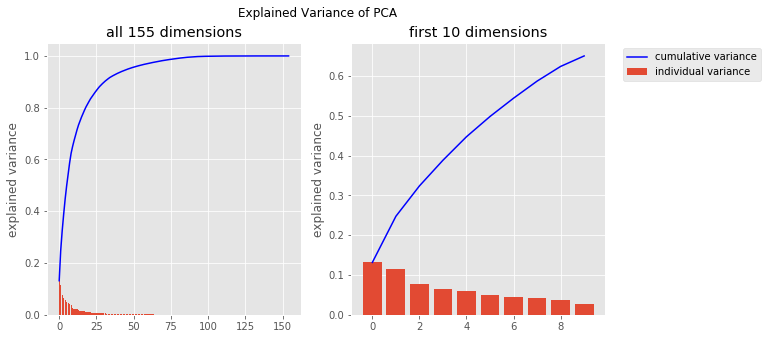

In [26]:
# look at PCA
from sklearn.decomposition import PCA
import seaborn as sns

# first split the data from the target
data_cols = list(imp_df)
data_cols.remove('readmitted')
data = imp_df[data_cols]
target = imp_df['readmitted']

# now do PCA on the data
pca = PCA(n_components=len(data_cols), random_state=1)
print('PCA model built!')

data_pca_fit = pca.fit_transform(data.copy())
#X_PCA = X_PCA_fit.transform(X)
explained_var = pca.explained_variance_ratio_
print("Orginal data dimension is {}. Embedded data dimension is {}".format(data.shape[-1], data_pca_fit.shape[-1]))
#print("cumulative explained variance : {}".format(np.cumsum(explained_var)))

fig = plt.figure(figsize = (10,5))
fig.suptitle('Explained Variance of PCA')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set(title='all {} dimensions'.format(len(data_cols)), ylabel='explained variance')
ax1.bar(np.arange(0,len(explained_var),1),explained_var)
ax1.plot(np.arange(0,len(explained_var),1), np.cumsum(explained_var), 'b-')
ax2.set(title='first 10 dimensions', ylabel='explained variance')
ax2.bar(np.arange(0,10,1),explained_var[:10])
ax2.plot(np.arange(0,10,1), np.cumsum(explained_var[:10]), 'b-')
ax2.legend(['cumulative variance', 'individual variance'], bbox_to_anchor=(1.05, 1))
plt.show()

[[  5.46835475e-01   8.01849699e-02   4.62458885e-01   3.32863659e-01]
 [  5.48813747e-01  -1.55821800e-01  -2.26212623e-01  -1.58004972e-01]
 [  5.11542977e-01  -7.02265590e-01   3.16730582e-02  -7.21587041e-03]
 [  5.22551339e-01   1.35803808e-01  -1.94046099e-01  -6.06131759e-01]
 [  5.43000320e-01  -3.17388066e-01   6.79316193e-04   3.39576014e-01]
 [  5.37042729e-01  -9.80991965e-03  -1.11478531e-01  -5.36134504e-03]
 [  5.78429098e-01   4.94847094e-01   2.48813714e-01   1.09044453e-01]
 [  4.91429895e-01   7.46644566e-02  -3.83794424e-01   5.02304668e-01]
 [  5.57225539e-01  -1.71599047e-01   6.04924137e-01  -2.19103383e-01]
 [  5.83658362e-01  -9.94436435e-02  -2.08542788e-01  -9.41936990e-03]]


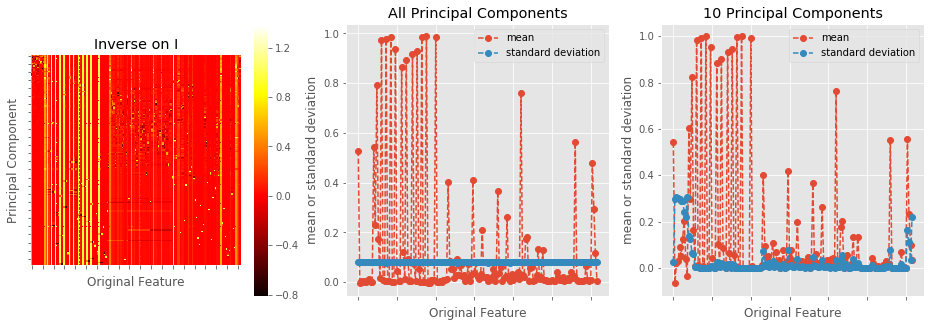

In [27]:
# now look at the features most contributing to the PCA

inv_dat = pca.inverse_transform(np.eye(data.shape[1]))
#inv_dat = pca.inverse_transform(np.diag(p_comp))
mean = inv_dat.mean(axis=0)
std = inv_dat.std(axis=0)
print(inv_dat[:10,:4])

mean_10 = inv_dat[:][:10].mean(axis=0)
std_10 = inv_dat[:][:10].std(axis=0)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,5))

axes[0] = sns.heatmap(inv_dat, cmap="hot", cbar=True, ax=axes[0])
axes[0].set(xlabel='Original Feature', ylabel='Principal Component', yticklabels=[], xticklabels=[], title='Inverse on I',
           aspect='equal')

axes[1].plot(mean, '--o', label='mean')
axes[1].plot(std, '--o', label='standard deviation')
axes[1].set(xlabel='Original Feature', ylabel='mean or standard deviation', xticklabels=[], title='All Principal Components')
axes[1].legend()

axes[2].plot(mean_10, '--o', label='mean')
axes[2].plot(std_10, '--o', label='standard deviation')
axes[2].set(xlabel='Original Feature', ylabel='mean or standard deviation', xticklabels=[], title='10 Principal Components')
axes[2].legend()

plt.show()

In the above left plot we can see a heat map of the result from applying the inverse PCA transform on an identity matrix. In this plot we can see that some of the original features contributed much more than others. 

On the center plot we have averaged the contributions from the orignal features over the principal components. This give us information about how much the original feature contributed to all of the components. 

On the right plot we have averaged over the first 10 principal components. This tells us what original features contribued to the 10 principal components that contributed the most to the total variance in the original dataset.

for a threshold of 0.1 we keep 31 features


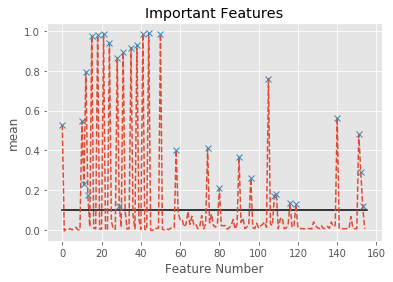

In [28]:
# now get the "most important" feautures from the original data
threshold = 0.1
ids = np.argwhere(mean > threshold)[:,0]
important_cols = [data_cols[i] for i in ids]
important_means = [mean[i] for i in ids]
print('for a threshold of {} we keep {} features'.format(threshold, len(important_cols)))
      
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Important Features')
ax.set_ylabel('mean')
ax.set_xlabel('Feature Number')
ax.plot([0,len(mean)], [threshold,threshold], 'k-', label = 'threshold')
ax.plot(mean, '--', label = 'mean')
ax.plot(ids, important_means, 'x')
plt.show()

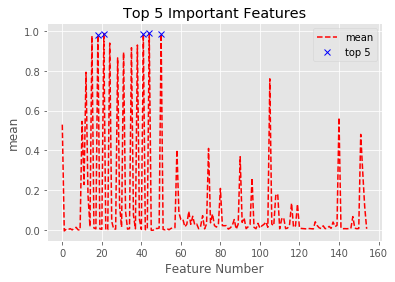

The top 5 most important features (in descending order) are 
1 = miglitol_category_No
2 = chlorpropamide_category_No
3 = acarbose_category_No
4 = glyburide-metformin_category_No
5 = nateglinide_category_No


In [29]:
# top 5
n_keep = 5
top_n_indices = sorted(range(len(mean)), key=lambda i: mean[i], reverse=True)[:n_keep]
top_n_means = [mean[i] for i in top_n_indices]
top_n_features = [data_cols[i] for i in top_n_indices]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Top {} Important Features'.format(n_keep))
ax.set_ylabel('mean')
ax.set_xlabel('Feature Number')
ax.plot(mean, 'r--', label = 'mean')
ax.plot(top_n_indices, top_n_means, 'bx', label='top {}'.format(n_keep))
ax.legend()
plt.show()

print('The top {} most important features (in descending order) are '.format(n_keep))
for j in range(n_keep):
    print('{} = {}'.format(j+1, top_n_features[j]))

Above we can see that we can find the "most important" features, or the features that contribute to the principal components the most. In this instance, we make a cut on the mean. We also find the 5 features that contribute the most. On a side note, these features are not at all what I would have expected.

<a id="phi_function"></a>
### Phi Functions

> One idea (__required for 7000 level students__): Implement two more phi functions: ReLU and SiLU (also called Swish). Compare their performance to the linear and sigmoid phi functions.

In [15]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.special import expit
from scipy.optimize import minimize_scalar

import copy

from numpy.linalg import pinv
from sklearn.datasets import load_iris
from scipy.optimize import fmin_bfgs

import multiprocessing as mp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

In [9]:
'''
Here, the val function gives the value of the activation, and the dev is the derivative value of the activation.
'''
class Linear:
    def val(x):
        return x
    def dev(x):
        return 1

class TANH:
    def val(x):
        return np.tanh(x)
    def dev(x):
        return 1 - np.tanh(x)*np.tanh(x)

class Sigmoid:
    def val(x):
        return 1 / (1 + np.exp(-x))
    def dev(x):
        return (1 / (1 + np.exp(-x))) * (1-1 / (1 + np.exp(-x)))

class Relu:    
    def val(x):
        return np.maximum(x.copy(),0)
    def dev(x):
        return (x>0).astype(int)

class ArcTan:    
    def val(x):
        return np.arctan(x)
    def dev(x):
        return 1/(x*x+1)
    
class SiLU:
    def val(x):
        return x / (1 + np.exp(-x))
    def dev(x):
        return x / (1 + np.exp(-x)) + (1-x / (1 + np.exp(-x))) / (1 + np.exp(-x))

'''
Here, we define the three different adaptive learning rates.
'''
def no_decay(eta,t,epoch):
    return eta

def exp_decay(eta,t,epoch):
    k = 0.001
    lrate = eta * np.exp(-k*t)
    return lrate

def inverse_decay(eta,t,epoch):
    lrate = eta /(1+t/epoch)
    return lrate

Above you can see the implementation of phi functions as well as adaptive learning rates. We included their performance comparison in the above work (such as [Hyper Parameters](#hyper_parameters)).

<a id="thoughts"></a>
## Final Thoughts

- We may be able to reduce the number of features be combining all of the medication columns into two features, the number of changes in medications and a second column containg the total number of medications taken by the patient. 

- We could also potentially reduce the dimensionality of our problem by combining the admission ids into groups. For instance admission source ids 1 (Emergency), 2 (Urgend), and 7 (Trauma Center) are all non-elective. Reducing the number of categories here would reduce the number of features afer one hot encoding.

- We may be able to make use of the HbA1c results by combining this column with the max glucose serum column. We could combine these into high, normal, low, and (potentially) not measured. Although the two individual columns were dropped because they didn't contain enough data, the combined result may have enough data to be used.

- We kept each individual result from patients who were included in the dataset multiple times (we kept rows with the same patient id). If we were to collapse these into a single column we would have to think about how to combine multiple stays. For example, the stay length could be the average of the stay lenghts for each individual encounter. Doing this would slightly change the question we want to answer with this project. By combining we could answer "how likely is a patient to be readmitted". This __more__